In [11]:
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchinfo import summary

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [12]:
TRAIN_DIR = "./deepglobe-land-cover-classification-dataset/train"
COLOR_CODES = "./deepglobe-land-cover-classification-dataset/class_dict.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

df = pd.read_csv(COLOR_CODES)
label_map = {}

for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
    
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [13]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg') and not filename.startswith("._")])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png') and not filename.startswith("._")])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB

        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return {"image": image, "mask": mask}
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [14]:

big_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)
[train_dataset, val_dataset, test_dataset] = torch.utils.data.random_split(big_dataset,[0.75,0.15,0.1], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

train_batch = next(iter(train_dataloader))

print(train_batch['image'].shape)
print(train_batch['mask'].shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])


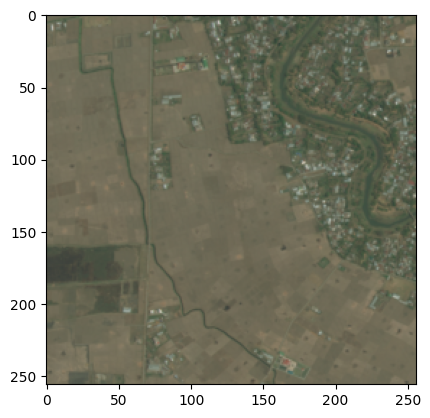

In [15]:
plt.imshow(np.transpose(train_batch['image'][0], (1, 2, 0)))

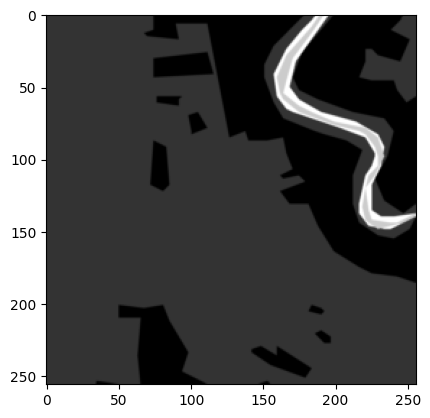

In [16]:
plt.imshow(np.transpose(train_batch['mask'][0], (1, 2, 0)), cmap='gray')

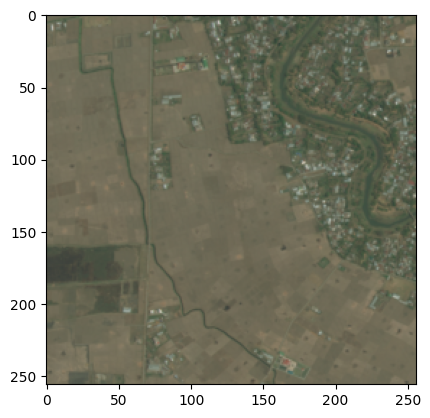

In [17]:
plt.imshow(np.transpose(train_batch['image'][0], (1, 2, 0)), cmap='gray')

In [18]:
class ModelCreate(L.LightningModule):

    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes):
        super().__init__()

        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights=encoder_weights)

        self.tp = None
        self.fp = None
        self.fn = None
        self.tn = None

        self.losses = {
            'valid': [],
            'train': [],
            'test': []
        }

        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

    def forward(self, image):

        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        assert mask.ndim == 4

        assert mask.max() <= 7.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="multiclass")

        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

        self.losses[stage].append(loss)

        return loss

    def shared_epoch_end(self, stage):
        tp = self.tp
        fp = self.fp
        fn = self.fn
        tn = self.tn

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True, logger=True)

    def training_step(self, batch):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [19]:
model = ModelCreate("UnetPlusPlus", "resnet50", 'imagenet',in_channels=3, out_classes=7)

In [20]:
earlystop_callback = EarlyStopping('valid_loss', patience=3)

trainer = L.Trainer(max_epochs=15, logger=CSVLogger(save_dir="logs/", name="unetpp-model"), callbacks=[earlystop_callback])

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | model   | UnetPlusPlus | 49.0 M
1 | loss_fn | DiceLoss     | 0     
-----------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.946   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\GlowingMan\.conda\envs\py3_10\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: one_hot is only applicable to index tensor.